# TinyVLM

## Data Exploration and Initial Preprocessing

### Pretraining Data

- [Images used for training with descriptions](https://huggingface.co/datasets/BAAI/CapsFusion-120M)

General Info on this Data:

- This dataset provides over 130 million image links, but we are scaling down. We downloaded the first 5 million rows of the dataset, and of these we will only use the rows where the image link gives a successful response code. For the purpose of data exploration, we are just using the first 100,000 rows.
- All initial images are not uniform in any regard, however during preprocessing, all images will be cropped (either center cropped or padded)
- 3 different descriptions for each images as features

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/image_metadata_0.csv')
df.head()

,image_url,capsfusion,identifier,original_width,original_height
0,http://ih3.redbubble.net/image.12080909.2547/f...,"The Lego minifigure, known as Minifig [Rainbow...",515623f9-0f34-49b1-be2c-253636badaf6,NaN,NaN
1,https://cdn.shopify.com/s/files/1/2161/7557/pr...,"The Chilly Grip H2O Waterproof Thermal Lined, ...",ccb9ec94-d0d4-4384-b728-a8d9ad150aa6,439.0,480.0
2,http://i0.wp.com/www.ladycarehealth.com/wp-con...,Abdominal cramping is a common sign of pregnan...,642a0186-bbc4-4244-b87b-617d4ea350ed,NaN,NaN
3,https://cdn.shopify.com/s/files/1/2986/1514/pr...,This lovely 1930s Velveteen Burgundy Half Slee...,9be0e45a-bdd0-410d-b825-77b3781eaa84,800.0,1156.0
4,https://cdn.shopify.com/s/files/1/2169/9777/pr...,The Bubblegum Divas Store offers a Little Yell...,b75f96ac-c759-415c-91de-4502da4a3156,100.0,100.0


#### Preprocessing Steps

For preprocessing, we plan on doing the following:

- Downloading only images in which gives a successful response code (rows in the dataset corresponding to images without a successful response code will be disregarded)
- Cropping all the images to a desired 448 x 448 dimension
- Classification of the data for data exploration
- Encorporate image descriptions to the desired images for training
- Prepare questions and answers for images to do instruction Tuning to the LLM pre-train model

Our dataset consists of images with a wide variety of aspect ratios. Some images are already square or nearly square, whereas others have extreme aspect ratios (very narrow/wide). To account for this, we will set an aspect ratio threshold of 0.6, where aspect ratio is defined as the minimum of the width and height over the maximum of the width and height. For images with an aspect ratio greater than or equal to 0.6, we will center crop the image, and images with an aspect ratio less than 0.6 will be padded. An example of our preprocessing for a single image is as follows: Say we have a very narrow image with a height of 400px and a width of 100px. The image will be padded to make it square, meaning black bars will be added to the left and right of the image, each one having a height of 400px and a width of 150px. The image will then be upscaled to 448x448.

Our function for preprocessing an image is below:

In [10]:
def preprocess_image(self, img):
    """
    Adaptively choose preprocessing method based on aspect ratio
    """
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    width, height = img.size
    aspect_ratio = min(width, height) / max(width, height)
    
    # Track which method was used
    if aspect_ratio >= self.aspect_ratio_threshold:
        # Use center crop for images with good aspect ratio
        for transform in self.crop_transforms:
            img = transform(img)
        with self.stats_lock:
            self.stats['crop_count'] += 1
    else:
        # Use padding for images with extreme aspect ratios
        img = self.resize_and_pad(img)
        with self.stats_lock:
            self.stats['pad_count'] += 1
    
    return img

#### Image Stats

24178
75822


Text(0.5, 1.0, 'Image download in total')

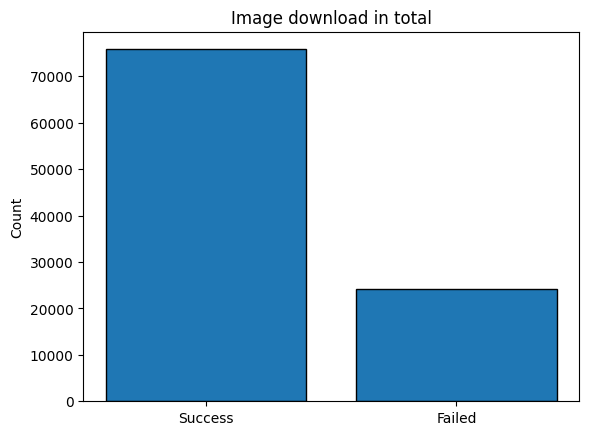

In [ ]:
fail_download = df.isna().any(axis=1).sum()
downloaded = df.shape[0] - fail_download
label = ['Success', 'Failed']
count = [downloaded, fail_download]
plt.bar(label, count,  edgecolor='black')
plt.ylabel('Count')
plt.title('Image download in total')

Drop all the null value and compute the aspect ratio for each picture

In [ ]:
df = df.dropna()
df['aspect_ratio'] = np.minimum(df['original_height'], df['original_width']) / np.maximum(df['original_height'], df['original_width'])
df.head()

,image_url,capsfusion,identifier,original_width,original_height,aspect_ratio
1,https://cdn.shopify.com/s/files/1/2161/7557/pr...,"The Chilly Grip H2O Waterproof Thermal Lined, ...",ccb9ec94-d0d4-4384-b728-a8d9ad150aa6,439.0,480.0,0.914583
3,https://cdn.shopify.com/s/files/1/2986/1514/pr...,This lovely 1930s Velveteen Burgundy Half Slee...,9be0e45a-bdd0-410d-b825-77b3781eaa84,800.0,1156.0,0.692042
4,https://cdn.shopify.com/s/files/1/2169/9777/pr...,The Bubblegum Divas Store offers a Little Yell...,b75f96ac-c759-415c-91de-4502da4a3156,100.0,100.0,1.000000
5,https://www.imore.com/sites/imore.com/files/st...,"Today only, Tweetbot for iPhone and iPad is on...",3f2e2dcc-9871-4c6b-88d1-5835256a594a,250.0,139.0,0.556000
6,https://i0.wp.com/moguldom.com/wp-content/uplo...,"Kenfield Griffith, an African American man wit...",25d86850-a70d-49a8-84d8-4a6766b46a3f,300.0,300.0,1.000000


Text(0.5, 1.0, 'Histogram of aspect_ratio')

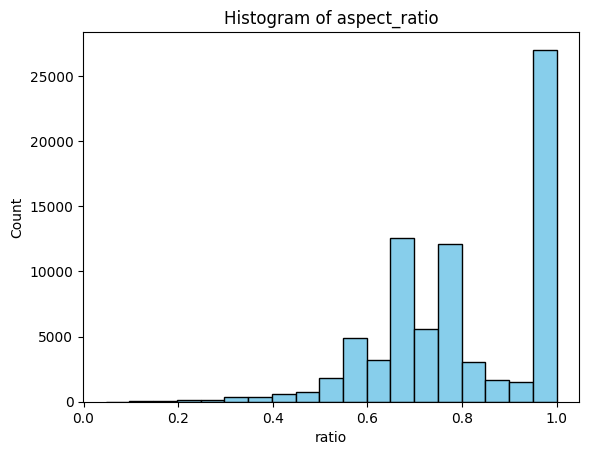

In [ ]:
plt.hist(df['aspect_ratio'], bins=19, edgecolor='black', color='skyblue')
plt.xlabel('ratio')
plt.ylabel('Count')
plt.title('Histogram of aspect_ratio')

### Image Classification for Data Exploration

#### Generating labels
Though it is possible to use a pretrained image classification model to classify our images, our dataset have much more diversed images than some datasets used fro pre-training the image classification models, for example ResNet trained on ImageNet. Thus we seek to generate our own bank of diverse image labels and untilize CLIP to classify each image into one specific class.

We create some CLIP labels to perform zero-shot image classification with the CLIP model. In the process of making the CLIP labels, we pass in some few-shot examples from a bif category into GPT in order to help generate more samples given a certain categorical inputs. From here, we are able to expand our CLIP labels from 10 for each individual categories we had, to 50-100 new labels for each different categories. Here, we will be able to classify images as more diverse labels than the predefined labels in some datasets.

The generated labels are availabe in "labels.py"

#### CLIP for Zero-Shot Classification

We utilized the zero shot classification ability of CLIP mode to classify the images in the dataset into our custom classes generated by Chat GPT.

In [ ]:
from classifier import ImageClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from collections import defaultdict
import pickle

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/open_clip/factory.py:372: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [ ]:
classifier_model = ImageClassifier()
result = classifier_model.process_directory("images/")

 21%|██        | 52/252 [03:17<12:34,  3.77s/it]

Error processing images/1116d007-e378-406b-9d77-b2e51fbd361a.jpg: cannot identify image file '/Users/anananan116/Documents/GitHub/TinyVLM/images/1116d007-e378-406b-9d77-b2e51fbd361a.jpg'


100%|██████████| 252/252 [15:54<00:00,  3.79s/it]


In [ ]:
labels_count = defaultdict(int)
for k,v in result.items():
    label = v['label']
    labels_count[label] += 1


In [ ]:
with open('labels_count.pickle', 'wb') as handle:
    pickle.dump(labels_count, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def plot_top_frequencies(counter: defaultdict, title: str = "Top 30 Most Frequent Classes", 
                        figsize: tuple = (12, 6), rotation: int = 45):
    """
    Plot a horizontal bar chart of the top 30 most frequent classes from a defaultdict counter.
    
    Parameters:
    -----------
    counter : collections.defaultdict
        A defaultdict(int) containing class counts
    title : str
        Title for the plot
    figsize : tuple
        Figure size as (width, height)
    rotation : int
        Rotation angle for x-axis labels
    """
    # Convert defaultdict to pandas Series and sort
    freq_series = pd.Series(dict(counter)).sort_values(ascending=True)
    
    # Get top 30 items
    top_30 = freq_series.tail(30)
    
    plt.figure(figsize=figsize)
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(top_30)), top_30.values)
    
    # Customize the plot
    plt.title(title, pad=20)
    plt.xlabel('Count')
    plt.ylabel('Classes')
    
    # Set y-axis ticks
    plt.yticks(range(len(top_30)), top_30.index, rotation=0)
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, i, f' {width:,}', 
                va='center', ha='left')
    
    plt.show()

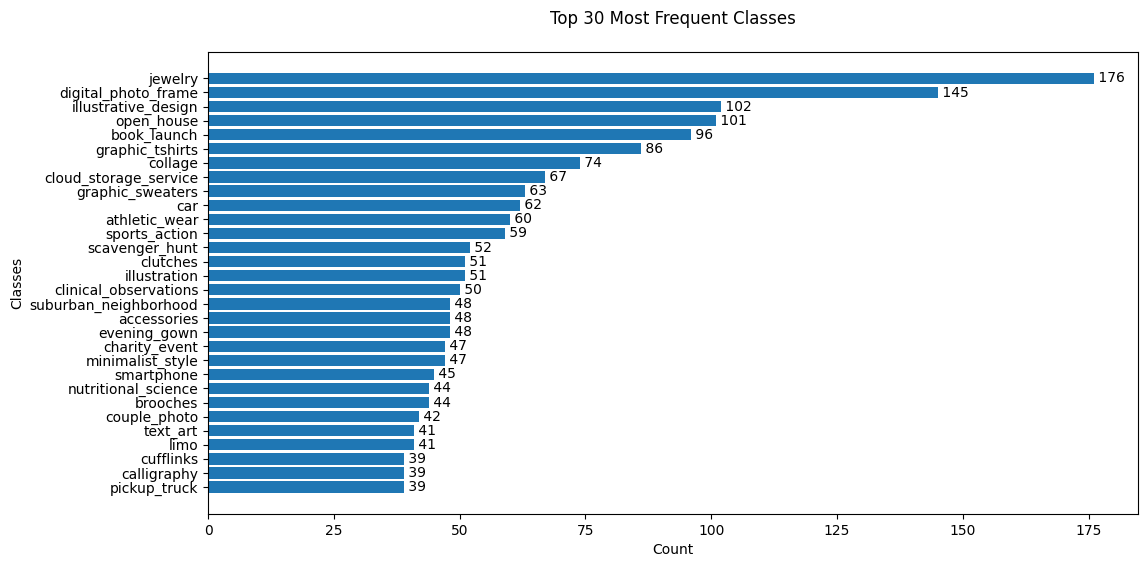

In [ ]:
plot_top_frequencies(labels_count, title="Top 30 Most Frequent Classes")

### Instruction Tunning Data

We are also using the following datasets for instruction tuning. The first dataset below contains questions, and second contains answers.

- [Instruction Tuning: VQA](https://visualqa.org/download.html)


In [ ]:
df_q.head()

,image_id,question,question_id
0,458752,What is this photo taken looking through?,458752000
1,458752,What position is this man playing?,458752001
2,458752,What color is the players shirt?,458752002
3,458752,Is this man a professional baseball player?,458752003
4,262146,What color is the snow?,262146000


In [ ]:
df_a.head()

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id
0,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",458752,other,458752000
1,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",458752,other,458752001
2,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",458752,other,458752002
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",458752,yes/no,458752003
4,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",262146,other,262146000
